In [1]:
from goodclips.ls_task import parse_mainjson_list,get_ballinplay_ts
from typing import cast
import pandas as pd
import os


## the exported annotations from the project

In [2]:
anno_data = parse_mainjson_list('../ungitable/project-1-at-2024-12-08-22-01-77c7417a.json')

## some basic aggregation info

In [3]:
from typing import cast

from goodclips.ls_task import Annotation, Data, get_clipevent_contact_ts

tasks: list[tuple[list[Annotation],Data]] = [(t.annotations,t.data) for t in anno_data if len(t.annotations)>0]
# for i,(anno,data) in enumerate(annos):
#     print(f"{i}:{get_ballinplay_ts(anno)},{get_clipevent_contact_ts(data)}")

count = sum(1 for annos, data in tasks if abs(get_ballinplay_ts(annos) - get_clipevent_contact_ts(data)) < 1 and get_clipevent_contact_ts(data) > 0)
percentage = (count / len(tasks)) * 100
print(f"Percentage of times the distance is < 1s and there was contact: {percentage:.2f}%")
contact_count = sum(1 for _, data in tasks if get_clipevent_contact_ts(data) > 0)
contact_percentage = (contact_count / len(tasks)) * 100
print(f"Percentage of times there was contact: {contact_percentage:.2f}%")
accuracy = percentage / contact_percentage
print(f"Accuracy for contact: {(accuracy*100):.2f}")

no_contact_agree_count = sum(1 for anno, data in tasks if abs(get_ballinplay_ts(anno) - get_clipevent_contact_ts(data)) < 1 and get_clipevent_contact_ts(data) <= 0)
no_contact_agree_percentage = (no_contact_agree_count / len(tasks)) * 100
print(f"Percentage of times the distance is < 1s and there was no contact: {no_contact_agree_percentage:.2f}%")
negative_contact_count = sum(1 for _, data in tasks if get_clipevent_contact_ts(data) < 0)
negative_contact_percentage = (negative_contact_count / len(tasks)) * 100
print(f"Percentage of times the clipevent contact time is < 0: {negative_contact_percentage:.2f}%")
no_contact_accuracy = no_contact_agree_percentage / negative_contact_percentage
print(f"Accuracy for no contact: {(no_contact_accuracy*100):.2f}")

Percentage of times the distance is < 1s and there was contact: 58.48%
Percentage of times there was contact: 72.81%
Accuracy for contact: 80.32
Percentage of times the distance is < 1s and there was no contact: 20.25%
Percentage of times the clipevent contact time is < 0: 27.19%
Accuracy for no contact: 74.46


## Create a dataframe with the pertinant information, and whether there is a deepsort file to work from


In [4]:
# Create a list of dictionaries with the required information
data_list = [{
    'clipId': data.clipId,
    'text_brief': data.textDescriptionBrief,
    'ballinplay_ts': get_ballinplay_ts(anno),
    'clipevent_ts': get_clipevent_contact_ts(data),
    'text_full': data.textDescription[:20],
    'has_clipevent_contact': get_clipevent_contact_ts(data) > 0,
    'has_ballinplay': get_ballinplay_ts(anno) > 0,
    'agree': abs(get_ballinplay_ts(anno) - get_clipevent_contact_ts(data)) < 3,
    'distance': abs(get_ballinplay_ts(anno) - get_clipevent_contact_ts(data)),
} for anno, data in tasks]
# # print(data_list[:5])
# # Create a pandas dataframe from the list of dictionaries
df = pd.DataFrame(data_list)
df.head(10)

# Define the directory path
deepsort_dir = '../ungitable/deepsort'

# Add a new column to the dataframe
df['file_exists'] = df['clipId'].apply(lambda clipId: os.path.isfile(os.path.join(deepsort_dir, f"{clipId}.mp4.deepsort.json")))

# Display the updated dataframe
df[df['file_exists'] == True].head(10)

,clipId,text_brief,ballinplay_ts,clipevent_ts,text_full,has_clipevent_contact,has_ballinplay,agree,distance,file_exists
0,20rklLb793TvVuzD,single,25.875000,24.928,Mason bot 2nd single,True,True,True,0.947000,True
1,7qHyeBUcNuXt7KMR,out,27.083333,24.320,Ethan pitched out in,True,True,True,2.763333,True
2,D1b2ZrQuEdo6mLEl,triple,24.541667,24.336,Coby bot 3rd triple,True,True,True,0.205667,True
3,M8E6uaAujZkL0Lyc,out,17.750000,-1.000,Emily pitched out in,False,True,False,18.750000,True
4,382LnPm2cD9NMt3P,single,26.625000,26.240,Reese top 1st single,True,True,True,0.385000,True
5,2hVkAP3woJGeix9e,single,15.875000,15.696,Kadence bot 1st sing,True,True,True,0.179000,True
6,QQC1wZtPJtaC0cy2,single,15.541667,15.104,Sophia top 2nd singl,True,True,True,0.437667,True
7,2cKVta2pHP2Eq2ts,double,16.125000,15.616,Jack bot 5th double,True,True,True,0.509000,True
8,76IjK5NR3tlO1087,single,11.166667,28.192,Zoe bot 5th single v,True,True,False,17.025333,True
9,G8DYv6aSExcZbF5l,flyout,23.041667,22.576,Ella pitched flyout,True,True,True,0.465667,True


## we only want to check the ones where the clip event is wrong

In [5]:
df_contact = df[df['has_clipevent_contact'] == True]
df_false_positive = df_contact[df_contact['agree'] == False]
df_checkable_fps = df_false_positive[df_false_positive['file_exists'] == True]
df_checkable_fps.head(10)

,clipId,text_brief,ballinplay_ts,clipevent_ts,text_full,has_clipevent_contact,has_ballinplay,agree,distance,file_exists
8,76IjK5NR3tlO1087,single,11.166667,28.192,Zoe bot 5th single v,True,True,False,17.025333,True
11,6cCuJiEJBNTx8bHz,triple,16.708333,43.024,Bella bot 1st triple,True,True,False,26.315667,True
16,3SY8Kwi01HN5p7K8,single,16.791667,5.136,Amelia bot 2nd singl,True,True,False,11.655667,True
18,18d4IGOE3bHpdncV,double,19.458333,8.064,Adaeze bot 3rd doubl,True,True,False,11.394333,True
23,6vxfBUNVdGVHvvIb,out,44.000000,9.888,Riley pitched out in,True,True,False,34.112000,True
37,4A1nnEONnVe4HVEC,out,6.958333,20.480,Brooke pitched out i,True,True,False,13.521667,True
47,1XnvOxehsgI0KdrS,double,13.208333,31.504,Josh bot 5th double,True,True,False,18.295667,True
49,AJrqySzFfQsNtdNA,single,26.666667,9.184,Ruby top 4th single,True,True,False,17.482667,True
55,BElDFU5I7lbE6aoX,single,-1.000000,39.744,Bryce bot 4th single,True,False,False,40.744000,True
57,8IGAat0QnHgTDBdc,double,12.583333,32.768,Addi bot 4th double,True,True,False,20.184667,True


## helper routine to get the deepsort data and the clip_row for a given id

In [6]:
import json

from goodclips.deepsort_types import DeepsortOutput
from goodclips.utils import parse_deepsort_output

def load_deepsort_output(clip_id: str, deepsort_dir: str, df: pd.DataFrame) -> tuple[DeepsortOutput,pd.Series]:
    file_path = os.path.join(deepsort_dir, f"{clip_id}.mp4.deepsort.json")
    clip_row = df[df['clipId'] == clip_id].iloc[0]
    if os.path.isfile(file_path):
        return (parse_deepsort_output(file_path),clip_row)
    else:
        raise FileNotFoundError(f"No deepsort output file found for clip ID: {clip_id}")



In [7]:
# Example usage
clip_id = '76IjK5NR3tlO1087'
(deepsort_output,clip_row) = load_deepsort_output(clip_id, deepsort_dir,df_checkable_fps)
print(clip_row)

clipId                       76IjK5NR3tlO1087
text_brief                             single
ballinplay_ts                       11.166667
clipevent_ts                           28.192
text_full                Zoe bot 5th single v
has_clipevent_contact                    True
has_ballinplay                           True
agree                                   False
distance                            17.025333
file_exists                              True
Name: 8, dtype: object


## create a dataframe for the movement in the video.
resample it so that we have time series data : movement for every second in the clip

In [8]:
from goodclips.utils import create_movement_by_frame

def create_movement_timeseries(deepsort_output: DeepsortOutput) -> pd.DataFrame:
    mv = create_movement_by_frame(deepsort_output)
    mv_df = pd.DataFrame(mv)
    mv_df['ts'] = pd.to_datetime(mv_df['ts'], unit='s')

    # Set the 'ts' column as the index and convert it to a datetime index
    mv_df.set_index('ts', inplace=True)

    # Resample the dataframe into 500ms intervals and calculate the mean movement for each interval
    mv_df_resampled = mv_df.resample('1000ms').sum()

    mv_df.reset_index(inplace=True)

    # Reset the index to get 'ts' back as a column
    mv_df_resampled.reset_index(inplace=True)
    return mv_df_resampled


In [9]:
mv_by_frame = create_movement_timeseries(deepsort_output)
mv_by_frame.head()

,ts,movement
0,1970-01-01 00:00:00,331.996660
1,1970-01-01 00:00:01,455.693157
2,1970-01-01 00:00:02,351.846738
3,1970-01-01 00:00:03,573.491056
4,1970-01-01 00:00:04,527.601809


## plot the movement timeseries, 
with time markers for the label and clipevent contact 

In [10]:
import matplotlib.pyplot as plt

def plot_movement_timeseries(mv_df_resampled: pd.DataFrame, clip_row: pd.Series,confidence:float) -> None:
    # Plot the resampled dataframe as a time series
    plt.figure(figsize=(12, 3))
    plt.plot(mv_df_resampled['ts'], mv_df_resampled['movement'], marker='o', linestyle='-')
    plt.title(f'[{clip_row["clipId"]}] Movement Over Time: Clip Confidence: {confidence:.2f}')
    plt.xlabel('Timestamp')
    plt.ylabel('Movement')
    plt.grid(True)
    # Add a vertical line to mark the clipevent timestamp
    clipevent_ts = pd.to_datetime(clip_row['clipevent_ts'], unit='s')
    plt.axvline(x=clipevent_ts, color='r', linestyle='--', label=f'Clipevent Timestamp: {clip_row["clipevent_ts"]:.2f}s')
    clipevent_ts = pd.to_datetime(clip_row['ballinplay_ts'], unit='s')
    plt.axvline(x=clipevent_ts, color='g', linestyle='--', label=f'label Timestamp: {clip_row["ballinplay_ts"]:.2f}s')
    plt.legend()
    plt.show()

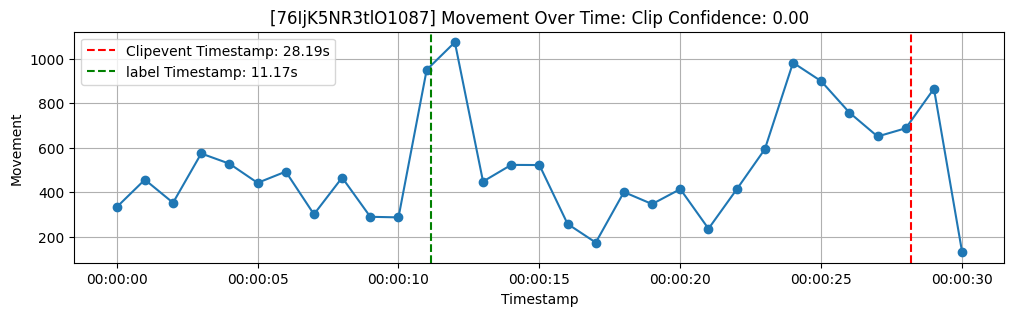

In [11]:
plot_movement_timeseries(mv_by_frame, clip_row,0.0)

In [ ]:
def calculate_confidence_score(mv_df_resampled: pd.DataFrame, clipevent_ts:pd.Timestamp) -> float:
    clipevent_ts += pd.Timedelta(seconds=0.5)
    # Find the index of the data point immediately previous to the clip event timestamp
    previous_index = mv_df_resampled[mv_df_resampled['ts'] < clipevent_ts].index[-1]
    
    max_movement = mv_df_resampled['movement'].max()
    max_movement_index = mv_df_resampled['movement'].idxmax()
    # Get the movement value at the previous index
    previous_value = mv_df_resampled.loc[previous_index, 'movement']
    
    # Initialize the confidence score
    confidence_score = 0.0
    # Check the next three data points
    max_proximate_movement = 0
    max_proximate_movement_index = 0
    for i in range(1, 4):
        next_index = previous_index + i
        if next_index < len(mv_df_resampled):
            next_value = mv_df_resampled.loc[next_index, 'movement']
            if next_value > previous_value: # type: ignore
                confidence_score += 0.25
            previous_value = next_value
            if next_value > max_proximate_movement: # type: ignore
                max_proximate_movement_index = next_index
                max_proximate_movement = next_value
    
    # Check if the maximum movement is within 10% of the overall maximum movement
    if max_proximate_movement_index >= max_movement_index and max_proximate_movement >= (max_movement*0.9): # type: ignore
        confidence_score += 0.25
    elif max_movement_index >= max_proximate_movement_index and max_movement_index < max_proximate_movement_index + 3: # type: ignore
        confidence_score += 0.25
    elif max_proximate_movement <= (max_movement*0.6):
        confidence_score -= 0.25
    return confidence_score

# Example usage
# clipevent_ts:pd.Timestamp = pd.to_datetime(clip_row['clipevent_ts'], unit='s')
# print (clipevent_ts)
# confidence_score = calculate_confidence_score(mv_df_resampled, clipevent_ts)
# print(f"Confidence Score: {confidence_score:.2f}")

## define a function that takes the dataframe and clip id as input, and generates a confidence score

In [42]:
def calc_confidence_for_clipid(clip_id: str, deepsort_dir: str, df: pd.DataFrame, plot:bool = False) -> float:
    try:
        (deepsort_output,clip_row) = load_deepsort_output(clip_id, deepsort_dir,df)
        mv_by_frame = create_movement_timeseries(deepsort_output)
        clipevent_ts = pd.to_datetime(clip_row['clipevent_ts'], unit='s')
        confidence_score = calculate_confidence_score(mv_by_frame, clipevent_ts)
        if plot:
            plot_movement_timeseries(mv_by_frame, clip_row, confidence_score)
        return confidence_score
    except FileNotFoundError as e:
        print(e)
        return 0.0

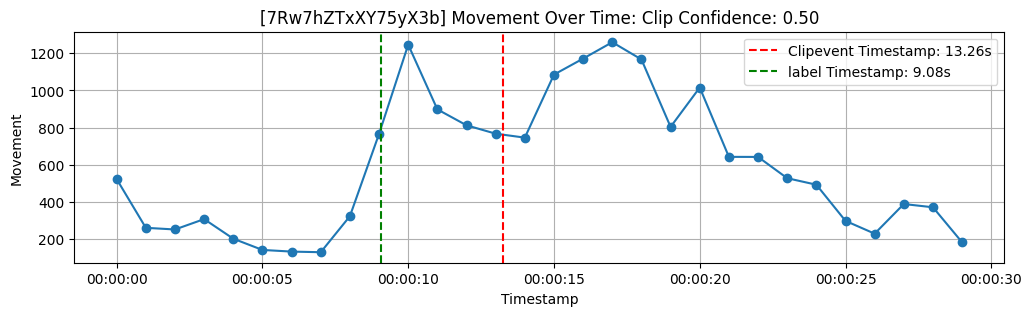

0.5

In [43]:
calc_confidence_for_clipid('7Rw7hZTxXY75yX3b', deepsort_dir, df, plot=True)

In [44]:
# Calculate confidence scores for the first 10 clip IDs in df_checkable_fps
confidence_scores = df_checkable_fps.head(10)['clipId'].apply(lambda clip_id: calc_confidence_for_clipid(clip_id, deepsort_dir, df_checkable_fps, plot=False))

# Display the confidence scores
confidence_scores

8     0.25
11   -0.25
16    0.00
18   -0.25
23    0.75
37    0.50
47    0.25
49    0.00
55   -0.25
57    0.25
Name: clipId, dtype: float64

In [45]:
# Filter the first 30 rows where file_exists is True
df_first_30 = df[(df['file_exists'] == True) & (df['has_clipevent_contact'] == True)].head(30).copy()

# Calculate confidence scores for each clipId in the new dataframe
df_first_30['confidence_score'] = df_first_30['clipId'].apply(lambda clip_id: calc_confidence_for_clipid(clip_id, deepsort_dir, df_first_30, plot=False))

# Display the new dataframe
df_first_30.head(30)

,clipId,text_brief,ballinplay_ts,clipevent_ts,text_full,has_clipevent_contact,has_ballinplay,agree,distance,file_exists,confidence_score
0,20rklLb793TvVuzD,single,25.875000,24.928,Mason bot 2nd single,True,True,True,0.947000,True,0.25
1,7qHyeBUcNuXt7KMR,out,27.083333,24.320,Ethan pitched out in,True,True,True,2.763333,True,0.50
2,D1b2ZrQuEdo6mLEl,triple,24.541667,24.336,Coby bot 3rd triple,True,True,True,0.205667,True,0.00
4,382LnPm2cD9NMt3P,single,26.625000,26.240,Reese top 1st single,True,True,True,0.385000,True,0.75
5,2hVkAP3woJGeix9e,single,15.875000,15.696,Kadence bot 1st sing,True,True,True,0.179000,True,0.00
6,QQC1wZtPJtaC0cy2,single,15.541667,15.104,Sophia top 2nd singl,True,True,True,0.437667,True,0.50
7,2cKVta2pHP2Eq2ts,double,16.125000,15.616,Jack bot 5th double,True,True,True,0.509000,True,0.50
8,76IjK5NR3tlO1087,single,11.166667,28.192,Zoe bot 5th single v,True,True,False,17.025333,True,0.25
9,G8DYv6aSExcZbF5l,flyout,23.041667,22.576,Ella pitched flyout,True,True,True,0.465667,True,0.50
10,3jcTkCX4Sew298p3,single,8.000000,7.600,Brennan bot 2nd sing,True,True,True,0.400000,True,0.50


In [46]:
df_checkable_fps['confidence_score'] = df_checkable_fps['clipId'].apply(lambda clip_id: calc_confidence_for_clipid(clip_id, deepsort_dir, df_checkable_fps, plot=False))
df_checkable_fps


/tmp/ipykernel_1960886/2124257104.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_checkable_fps['confidence_score'] = df_checkable_fps['clipId'].apply(lambda clip_id: calc_confidence_for_clipid(clip_id, deepsort_dir, df_checkable_fps, plot=False))


,clipId,text_brief,ballinplay_ts,clipevent_ts,text_full,has_clipevent_contact,has_ballinplay,agree,distance,file_exists,confidence_score
8,76IjK5NR3tlO1087,single,11.166667,28.192,Zoe bot 5th single v,True,True,False,17.025333,True,0.25
11,6cCuJiEJBNTx8bHz,triple,16.708333,43.024,Bella bot 1st triple,True,True,False,26.315667,True,-0.25
16,3SY8Kwi01HN5p7K8,single,16.791667,5.136,Amelia bot 2nd singl,True,True,False,11.655667,True,0.00
18,18d4IGOE3bHpdncV,double,19.458333,8.064,Adaeze bot 3rd doubl,True,True,False,11.394333,True,-0.25
23,6vxfBUNVdGVHvvIb,out,44.000000,9.888,Riley pitched out in,True,True,False,34.112000,True,0.75
...,...,...,...,...,...,...,...,...,...,...,...
1111,94QkIG5wTDyuq7V6,double,-1.000000,17.008,Zackary top 2nd doub,True,False,False,18.008000,True,0.25
1115,5Js2gS6ffG7HG5de,out,-1.000000,20.176,Analee pitched out i,True,False,False,21.176000,True,0.50
1116,02YoSiyGzEGP5P6F,out,16.333333,10.640,Lilyanna pitched out,True,True,False,5.693333,True,0.50
1126,3ZhzmcGmEqtYUaxx,single,11.375000,37.904,Neyland top 1st sing,True,True,False,26.529000,True,0.00


In [47]:
df_checkable_fps[df_checkable_fps['confidence_score'] > 0.5]

,clipId,text_brief,ballinplay_ts,clipevent_ts,text_full,has_clipevent_contact,has_ballinplay,agree,distance,file_exists,confidence_score
23,6vxfBUNVdGVHvvIb,out,44.000000,9.888,Riley pitched out in,True,True,False,34.112000,True,0.75
270,4jLAtF050H7JYzJO,triple,14.583333,31.680,Logan bot 2nd triple,True,True,False,17.096667,True,1.00
490,0CmnyKPQScJ6l68w,single,-1.000000,15.584,Chloe bot 4th single,True,False,False,16.584000,True,0.75
493,6aa5g1g287bu4mji,out,11.000000,24.592,Pierce pitched out i,True,True,False,13.592000,True,1.00
658,5vMvjxTsX8s6UFSy,single,5.083333,15.392,Joel (Papi) top 3rd,True,True,False,10.308667,True,0.75
680,4iqr0TNBgSwinMLx,double,14.125000,41.856,Hayden bot 4th doubl,True,True,False,27.731000,True,0.75
740,2Tmj3CTTRXDEDonx,out,10.791667,43.456,Moo pitched out in t,True,True,False,32.664333,True,0.75
1051,7HRUq8qto7N0xZaL,out,23.375000,28.992,Olivia pitched out i,True,True,False,5.617000,True,0.75


In [48]:
len(df_checkable_fps)

138

In [49]:
df_checkable_fps[df_checkable_fps['confidence_score'] > 0.5]

,clipId,text_brief,ballinplay_ts,clipevent_ts,text_full,has_clipevent_contact,has_ballinplay,agree,distance,file_exists,confidence_score
23,6vxfBUNVdGVHvvIb,out,44.000000,9.888,Riley pitched out in,True,True,False,34.112000,True,0.75
270,4jLAtF050H7JYzJO,triple,14.583333,31.680,Logan bot 2nd triple,True,True,False,17.096667,True,1.00
490,0CmnyKPQScJ6l68w,single,-1.000000,15.584,Chloe bot 4th single,True,False,False,16.584000,True,0.75
493,6aa5g1g287bu4mji,out,11.000000,24.592,Pierce pitched out i,True,True,False,13.592000,True,1.00
658,5vMvjxTsX8s6UFSy,single,5.083333,15.392,Joel (Papi) top 3rd,True,True,False,10.308667,True,0.75
680,4iqr0TNBgSwinMLx,double,14.125000,41.856,Hayden bot 4th doubl,True,True,False,27.731000,True,0.75
740,2Tmj3CTTRXDEDonx,out,10.791667,43.456,Moo pitched out in t,True,True,False,32.664333,True,0.75
1051,7HRUq8qto7N0xZaL,out,23.375000,28.992,Olivia pitched out i,True,True,False,5.617000,True,0.75


In [50]:
for x in (list(df_checkable_fps[df_checkable_fps['confidence_score'] > 0.5]['clipId'])):
    print(x)

6vxfBUNVdGVHvvIb
4jLAtF050H7JYzJO
0CmnyKPQScJ6l68w
6aa5g1g287bu4mji
5vMvjxTsX8s6UFSy
4iqr0TNBgSwinMLx
2Tmj3CTTRXDEDonx
7HRUq8qto7N0xZaL


In [51]:
baddies = (list(df_checkable_fps[df_checkable_fps['confidence_score'] > 0.5]['clipId']))

bad_tasks = [t[1].fileDownloadUrl for t in tasks if t[1].clipId in baddies]
for bt in bad_tasks:
    print(bt)

https://f000.backblazeb2.com/file/shd-clip-23/20240510tr__top1__6vxfBUNVdGVHvvIb
https://f000.backblazeb2.com/file/shd-clip-23/20240329sg__bot2__4jLAtF050H7JYzJO
https://f000.backblazeb2.com/file/shd-clip-23/20240614lw__bot4__0CmnyKPQScJ6l68w
https://f000.backblazeb2.com/file/shd-clip-23/20240414qs__bot2__6aa5g1g287bu4mji
https://f000.backblazeb2.com/file/shd-clip-23/20240612lz__top3__5vMvjxTsX8s6UFSy
https://f000.backblazeb2.com/file/shd-clip-23/20240531ut__bot4__4iqr0TNBgSwinMLx
https://f000.backblazeb2.com/file/shd-clip-23/20240622wb__top2__2Tmj3CTTRXDEDonx
https://f000.backblazeb2.com/file/shd-clip-23/20240519ru__bot4__7HRUq8qto7N0xZaL


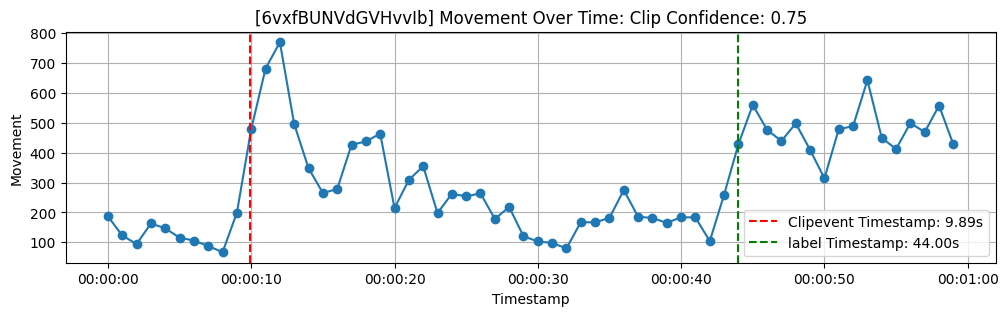

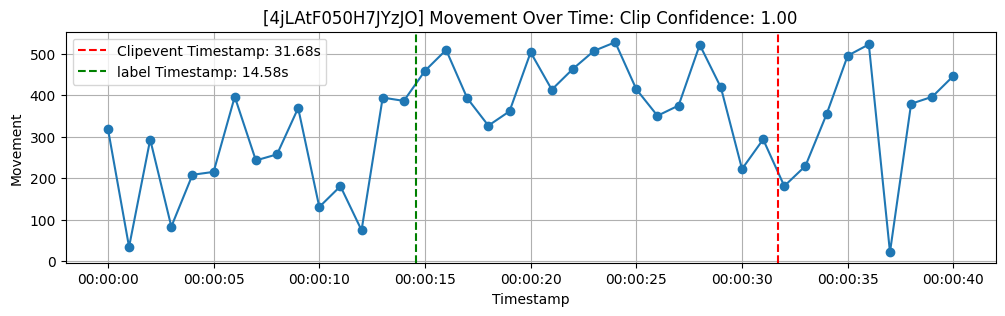

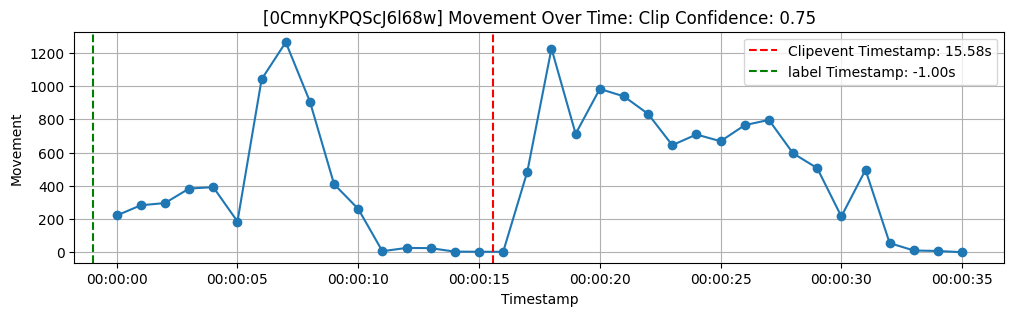

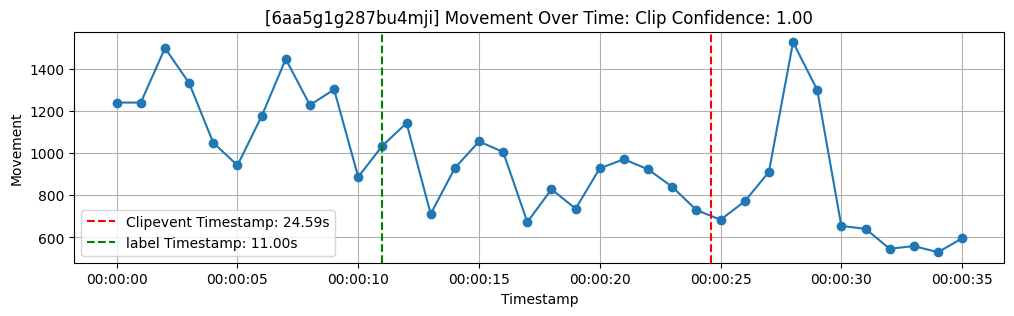

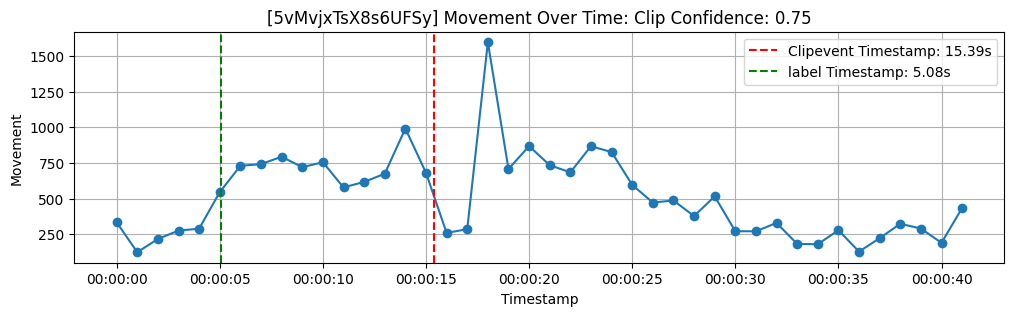

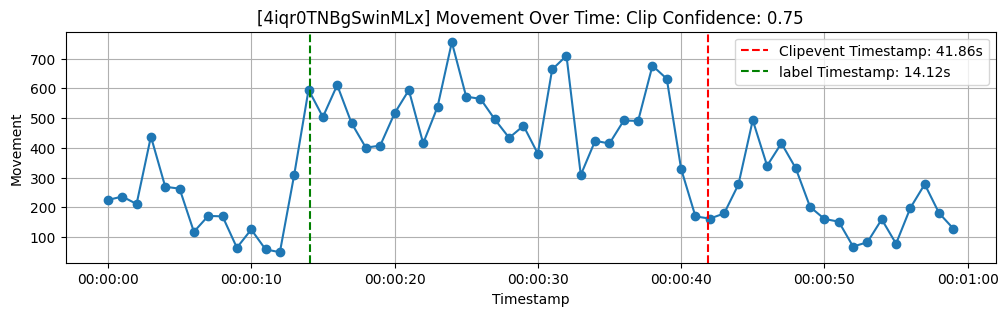

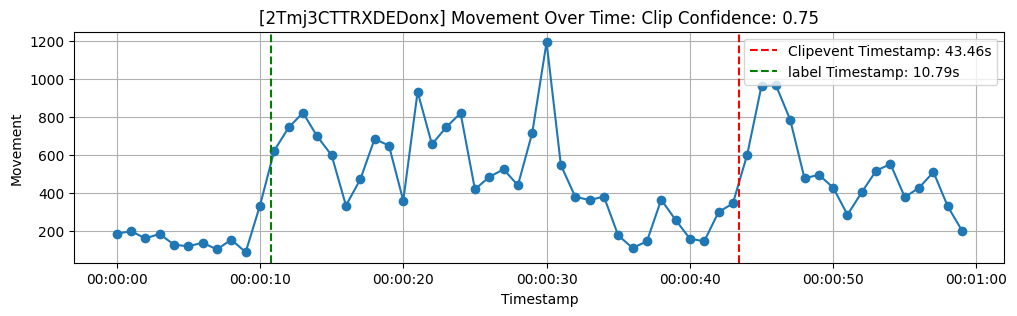

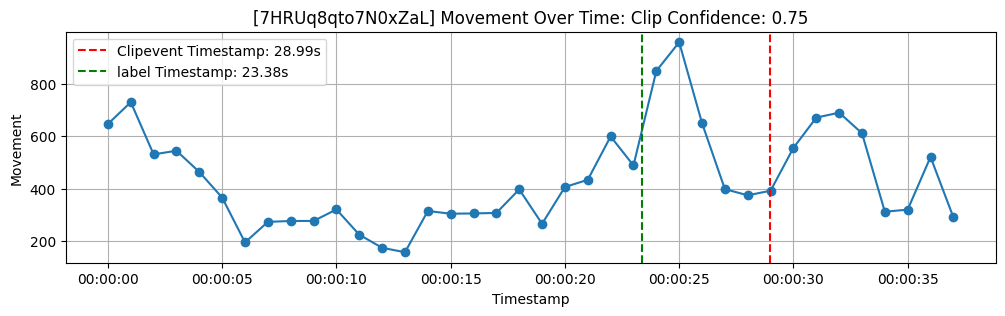

In [52]:
for x in (list(df_checkable_fps[df_checkable_fps['confidence_score'] > 0.5]['clipId'])):
    calc_confidence_for_clipid(x, deepsort_dir, df, plot=True)

## this takes a long time, so only do it sometimes
check on the ones where we agree, to see how many are false negatives

In [53]:
df_contact = df[df['has_clipevent_contact'] == True]
df_agree = df_contact[df_contact['agree'] == True]
df_agree['confidence_score'] = df_agree[df_agree['file_exists'] == True]['clipId'].apply(lambda clip_id: calc_confidence_for_clipid(clip_id, deepsort_dir, df_contact, plot=False))
df_false_negative = df_agree[df_agree['confidence_score'] < 0.75]
df_true_positive = df_agree[df_agree['confidence_score'] >= 0.75]


/tmp/ipykernel_1960886/2287105900.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_agree['confidence_score'] = df_agree[df_agree['file_exists'] == True]['clipId'].apply(lambda clip_id: calc_confidence_for_clipid(clip_id, deepsort_dir, df_contact, plot=False))


In [54]:
len(df_false_negative), len(df_true_positive)

(487, 228)

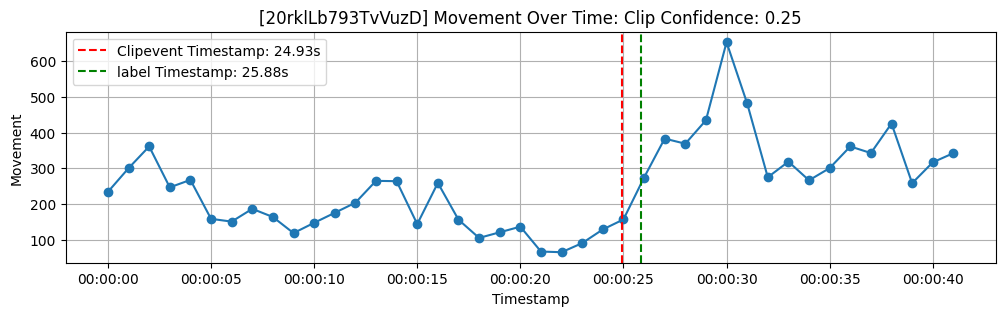

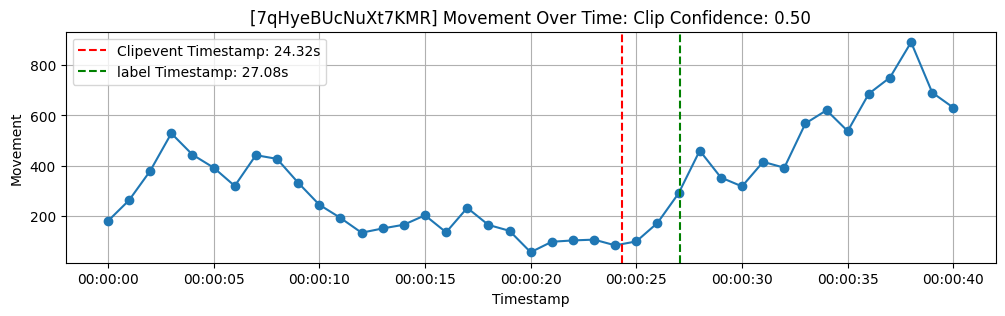

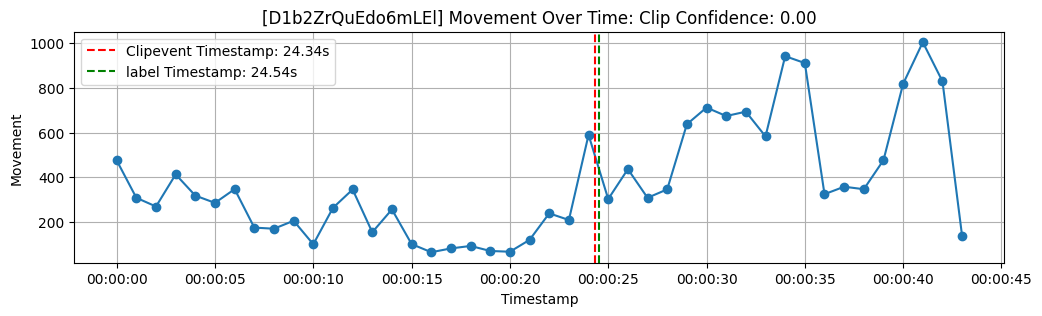

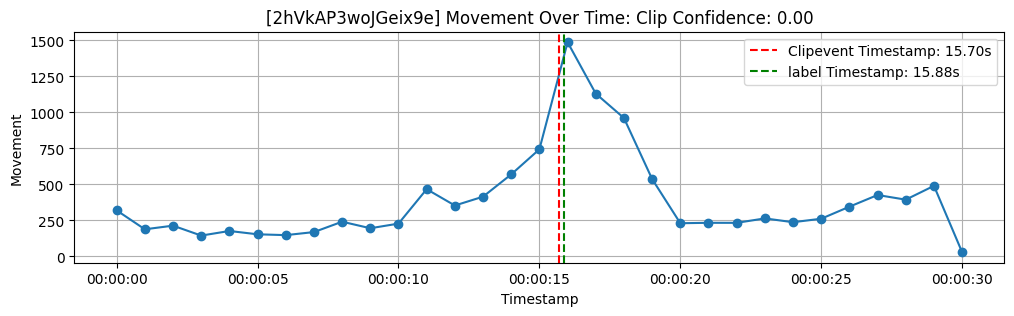

In [55]:
for x in (list(df_false_negative.head(4)['clipId'])):
    calc_confidence_for_clipid(x, deepsort_dir, df, plot=True)